<a href="https://colab.research.google.com/github/vilsaira/example/blob/main/dMRI_signal_GP_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and/or upgrade packages

In [ ]:
!pip install dipy #Install dipy to colab environment
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install pyDOE
!pip install scipy --upgrade # Upgrade packages if needed, remember to restart kernel afterwards!

     |████████████████████████████████| 7.7 MB 5.0 MB/s 
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=32ec101bafc017d73a448c6c9cb3d107bb8c829e64faf3f995d426a3fd449d99
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE
     |████████████████████████████████| 28.5 MB 49 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Get test data using dipy. Download takes about a minute. This example uses just b=1000 shell.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dipy.core.gradients import gradient_table
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.data import get_sphere, get_fnames

# Example from https://www.dipy.org/documentation/1.3.0./examples_built/reconst_mcsd/
sphere = get_sphere('symmetric724')

fraw, fbval, fbvec, t1_fname = get_fnames('cfin_multib')

data, affine = load_nifti(fraw)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

bvals = gtab.bvals
bvecs = gtab.bvecs

#sel_b = np.logical_or(np.logical_or(bvals == 0, bvals == 1000), bvals == 2000)
sel_b = np.logical_or(bvals == 0, bvals == 1000)
data = data[..., sel_b]

gtab = gradient_table(bvals[sel_b], bvecs[sel_b])
bvals = gtab.bvals
bvecs = gtab.gradients

  0%|          | 0/1409 [00:00<?, ? MB/s]

  0%|          | 0/10603 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

Gaussian Process needs the angular distances between b-vectors.

In [ ]:
from scipy.optimize import minimize
from pyDOE import lhs
from scipy.linalg import cholesky, cho_solve, solve


def _unit_vector(vector):
    return vector / np.linalg.norm(vector)

def _angle_between(v1, v2):
    v1_u = _unit_vector(v1)
    v2_u = _unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angles(bvecs1, bvecs2):
    n = bvecs1.shape[0]
    m = bvecs2.shape[0]
    C = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            # Select smallest of two arccos|<g1,g2>| and arccos|<g1,-g2>|
            C[i,j] = np.min((
                _angle_between(bvecs1[i,:], bvecs2[j,:]), # g1, g2
                 _angle_between(bvecs1[i,:], -bvecs2[j,:]))) #g1, -g2

    return C

Covariance matrix or kernel based on a spherical model (Eq. 10) for one shell case

In [ ]:
def kernel_ss(lmbda, a, theta):
    # Single shell kernel
    # Exponential model (Eq. 9)
    # K = lmbda * np.exp(-theta/a)
    # Spherical model (Eq. 10)
    K = lmbda**2 * (theta <= a) * (1 - 1.5*theta/a + 0.5*(theta/a)**3)
    return K

Legacy, use Leave-One-Out Cross Validation approach instead

Log marginal likelihood function which returns the negative value for scipy minimization.

In [ ]:
def likelihood(params, theta11, y):

    lmbda = np.log(params[0])
    a = params[1]
    sigmasq = np.log(params[2])
    n = y.shape[0]

    Ky = kernel_ss(lmbda, a, theta11) + (sigmasq**2) * np.eye(n) + 1e-10 * np.eye(n)
    # The last term of Ky (+1e10..) helps to avoid numerical problems in cholesky
    L = cholesky(Ky, lower=True)
    #Ky_inv = np.linalg.inv(Ky)

    # |Ky| = np.det(Ky)
    # If A = L@L.T then det(A) = prod(diag(L**2)), using log, prod -> sum and square term eats 0.5 factor in front of eq 12 second term
    LnDetKy = np.sum( np.log( np.abs( np.diagonal(L))))

    # over all voxels
    # vector version
    alphas = cho_solve((L.T, True), cho_solve((L, True), y)) # == Ky^-1 @ y)
    likes = -0.5 * y.T @ alphas - LnDetKy    
    # trace is the sum over all voxels
    like = np.trace(likes)
    # loop version - much slower
    # like = 0
    #for i in range(y.shape[1]):
    #    alpha = solve(L.T, solve(L, y[:,i]))
    #    like += (-0.5 * y[:,i].T @ alpha - LnDetKy).flatten()
    #    #y1 = np.atleast_2d(y[:,i]).T
    #    #alpha = cho_solve((L.T,True), cho_solve((L, True), y1))
    #    #like += (-0.5 * y1.T @ Ky_inv @ y1 - 0.5*np.log(np.linalg.det(Ky))).flatten()

    # Return negative value to maximize likelihood with scipy minimization
    return -like

Leave-One-Out Cross Validation (LOOCV) approach

In [ ]:
def loo(params, theta11, theta12, y):
    lmbda = params[0]
    a = params[1]
    sigmasq = params[2]

    n = y.shape[0]
    m = y.shape[1]
    one = np.ones((n-1,1)) 

    all_inds = np.arange(0,n)
    diffs = 0
    for i in range(n):        
        test_inds = i
        train_inds = np.delete(all_inds, i)
        
        train_theta = np.delete(theta11, i, 0) # delete row
        train_theta = np.delete(train_theta, i, 1) # delete column
        y_train = np.delete(y, i, 0)
        test_theta = np.delete(theta12,i,0)
        y_test = y[i,:]

        # Kernel of noisy observations
        K = kernel_ss(lmbda, a, train_theta) + (sigmasq**2) * np.eye(n-1) + 1e-10 * np.eye(n-1)
        K_s = kernel_ss(lmbda, a, test_theta)
        K_inv = np.linalg.inv(K)

        mus = K_s.T.dot(K_inv).dot(y_train)
        diffs += np.sum((mus[i,:] - y_test)**2)
    return diffs / n

GP prediction function

In [ ]:
def posterior(params, theta11, theta12, theta22, y):

    lmbda = params[0]
    a = params[1]
    sigmasq = params[2]
    n = y.shape[0]       

    Ky = kernel_ss(lmbda, a, theta11) + (sigmasq**2) * np.eye(n) + 1e-10 * np.eye(n)
    # Kernel of observations vs to-predict
    k12 = kernel_ss(lmbda, a, theta12)
    solved = solve(Ky, k12, assume_a='pos').T
    # posterior mean
    pmu = solved @ y
    # posterior covariance
    k22 = kernel_ss(lmbda, a, theta22)
    cov = k22 - (solved @ k12)
    std = np.sqrt(np.diag(cov))

    return pmu, std

Get **theta** matrix [#ndwi, #ndwi] that contain angular distances and matrix **y** [#ndwi, #nvox] that contain DWI signals 

In [ ]:
N_vox = 5000 # number of voxels used in GP
np.random.seed(seed=42)

bvecs1 = bvecs[~gtab.b0s_mask,:]
bvecs2 = bvecs[~gtab.b0s_mask,:]
# thetaxx matrices contain the angular distances between b-vecs [0, pi/2]
# For observation kernel
theta11 = angles(bvecs1, bvecs1)
# for observations to-predic kernel (i.e. if wants to predict new or missing vectors)
theta12 = angles(bvecs1, bvecs2)
# for posterior covariance
theta22 = angles(bvecs2, bvecs2)

# apply rough brain masking
brain_mask = np.sum(data[:,:,:,1:], axis=3) > 3000
data1 = data * brain_mask[:,:,:,None]
data1 = data1.reshape(np.prod(brain_mask.shape), data1.shape[-1]).astype(np.float32)
idx = np.argwhere(data1[:,0] > 0)

# select N_vox random voxels within the brain mask
selection = np.random.choice(idx.flatten(), N_vox)

y = data1[selection,np.argwhere(~gtab.b0s_mask)]
y = np.log(y)
y = y - np.mean(y)

Set number of iterations, bounds for the optimization, and get random initial parameters.

In [ ]:
n_repeats = 50
bounds = np.array([[0, 100], [1e-10, np.pi/2], [0, 50]])
lhd = lhs(3, n_repeats)
initial_params = (bounds[:,1] - bounds[:,0]) * lhd + bounds[:,0]

Run minimization and find the best solution over all N voxels (default = 1000)

In [ ]:
# This takes few seconds so results are also hardcoded to the next step
opt_para = np.zeros((n_repeats,3))
opt_fun = np.zeros((n_repeats,1))
for i in range(n_repeats):    
    res = minimize(loo, initial_params[i,:], args=(theta11, theta12, y),method='L-BFGS-B', bounds=bounds, options={'xtol': 1e-3, 'disp': True}) # Nelder-Mead L-BFGS-B
    opt_para[i,:] = res.x
    opt_fun[i,:] = res.fun
    print(f"{i} : params = [{res.x}] : likelihood = {res.fun}")

params = opt_para[np.argmin(opt_fun)]
print(params)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: OptimizeWarning: Unknown solver options: xtol
  """


0 : params = [[41.98796969  1.57079633 17.03635237]] : likelihood = 49.18614732097757
1 : params = [[9.32193949e+01 2.35612475e-02 2.87643534e+01]] : likelihood = 287.2722516779571
2 : params = [[65.37848592  1.57079633 26.52693808]] : likelihood = 49.18614732097784
3 : params = [[32.89533813  1.57079633 13.34709081]] : likelihood = 49.18614732097779
4 : params = [[25.97898912  1.57079633 10.54079848]] : likelihood = 49.186147320990756
5 : params = [[64.36340177  1.57079633 26.11514515]] : likelihood = 49.186147321035904
6 : params = [[60.84977223  1.57079633 24.68931973]] : likelihood = 49.186147321069534
7 : params = [[94.84631844  1.57079633 38.48327699]] : likelihood = 49.18614732098081
8 : params = [[40.19167     1.57079633 16.30753365]] : likelihood = 49.18614732097737
9 : params = [[49.8365441   1.57079633 20.22096039]] : likelihood = 49.18614732107384
10 : params = [[74.51569281  1.57079633 30.23380874]] : likelihood = 49.18614732230542
11 : params = [[82.09279534  1.57079633 3

Get another random brain voxel and use the GP model to predict its signal.

The problem in the obtained parameters is that both 'lambda' and 'a' get as high as boundaries allow. This typically means that found solution is not a global minimum.

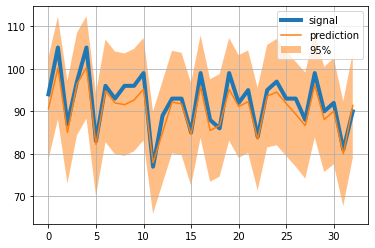

In [ ]:
params = np.array([18.61308973,  1.57079633,  7.54946033])
while True:
  selection2 = np.random.choice(idx.flatten(), 1)
  if np.sum(selection2 == selection) == 0:
    break # test data is not part of training data

y0 = data1[selection2,np.argwhere(~gtab.b0s_mask)]
y1 = data1[selection2,np.argwhere(~gtab.b0s_mask)]

#y1 = y1 - np.mean(y1)
pred, std = posterior(params, theta11, theta12, theta22, y1)
pred = pred.flatten()

plt.plot(y1, label='signal', linewidth=4, color='C00')
plt.plot(pred, label='prediction', color='C01')
plt.fill_between(np.linspace(0, len(pred)-1, len(pred)), pred+1.96*std, pred-1.96*std, label='95%', alpha=0.5, facecolor='C01')
plt.legend()
plt.grid()

Adding outliers highlight the failed optimization: model with these parameters is not robust towards outliers.

Difference between outlier and corresponding prediction: [4.4] stds
Average difference other points and corresponding predictions: 1.2 stds


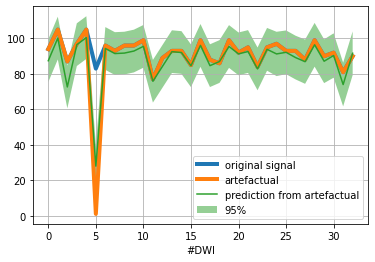

In [ ]:
y1 = data1[selection2,np.argwhere(~gtab.b0s_mask)]
# OUTLIER
oi = np.array([5]) #, 17, 28, 15, 20, 25, 10, 3, 12, 7])
non_out_inds = np.arange(len(y1))
non_out_inds = np.delete(non_out_inds, oi)
y1[oi] = 1.1
#y0 = y0 - np.mean(y0)
#y1 = y1 - np.mean(y1)
pred, std = posterior(params, theta11, theta12, theta22, y1)
pred = pred.flatten()

plt.plot(y0, label='original signal', linewidth=4, color='C00')
plt.plot(y1, label='artefactual', linewidth=4, color='C01')
plt.plot(pred, label='prediction from artefactual', color='C02')
plt.fill_between(np.linspace(0, len(pred)-1, len(pred)), pred+1.96*std, pred-1.96*std, label='95%', alpha=0.5, facecolor='C02')
plt.legend()
plt.grid()
#plt.ylabel('STD')
plt.xlabel('#DWI')
print(f'Difference between outlier and corresponding prediction: {np.round(np.abs(pred[oi]-y1[oi].flatten())/std[oi],1)} stds')
print(f'Average difference other points and corresponding predictions: {np.round(np.average(np.abs(pred[non_out_inds]-y1[non_out_inds])/std[non_out_inds]),1)} stds')